In [1]:
# Importing Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from openpyxl import load_workbook
from pyomo.environ import *

In [2]:
from __future__ import division
from pyomo.opt import SolverFactory

In [3]:
# Reading the data from Excel workbook
InputData = "Staffing+Data.xlsx"
StaffAv = pd.read_excel(InputData, sheet_name="StaffAvailability")
Cost = pd.read_excel(InputData, sheet_name="Cost")
transCost = pd.read_excel(InputData, sheet_name="ServiceRate")
Demand_data = pd.read_excel(InputData, sheet_name="DemandData")

In [4]:
StaffAv.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [5]:
Cost.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180
1,A,Feb,60000,5000.0,180
2,A,Mar,60000,5000.0,180
3,A,Apr,60000,5000.0,180
4,A,May,60000,5000.0,180


In [6]:
transCost.head()

,MgAppServedPerMonth
0,40


In [7]:
Demand_data.head()

,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


## Data pre-processing 

## Parameters

In [8]:
# Create the required Python data structures for indexes and parameters
Demand = Demand_data.set_index(['State','Month'])['Demand'].to_dict()
Demand

{('A', 'Jan'): 5240,
 ('A', 'Feb'): 4878,
 ('A', 'Mar'): 5942,
 ('A', 'Apr'): 2297,
 ('A', 'May'): 1992,
 ('A', 'Jun'): 2275,
 ('A', 'Jul'): 5334,
 ('A', 'Aug'): 3371,
 ('A', 'Sep'): 3759,
 ('A', 'Oct'): 3529,
 ('A', 'Nov'): 4284,
 ('A', 'Dec'): 5183,
 ('B', 'Jan'): 4927,
 ('B', 'Feb'): 2628,
 ('B', 'Mar'): 2974,
 ('B', 'Apr'): 2338,
 ('B', 'May'): 4020,
 ('B', 'Jun'): 3147,
 ('B', 'Jul'): 4271,
 ('B', 'Aug'): 2620,
 ('B', 'Sep'): 4517,
 ('B', 'Oct'): 4155,
 ('B', 'Nov'): 3137,
 ('B', 'Dec'): 4227,
 ('C', 'Jan'): 1162,
 ('C', 'Feb'): 1967,
 ('C', 'Mar'): 1898,
 ('C', 'Apr'): 2261,
 ('C', 'May'): 2030,
 ('C', 'Jun'): 1642,
 ('C', 'Jul'): 2489,
 ('C', 'Aug'): 2496,
 ('C', 'Sep'): 922,
 ('C', 'Oct'): 2421,
 ('C', 'Nov'): 963,
 ('C', 'Dec'): 1998}

In [9]:
Cost.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180
1,A,Feb,60000,5000.0,180
2,A,Mar,60000,5000.0,180
3,A,Apr,60000,5000.0,180
4,A,May,60000,5000.0,180


In [10]:
FTE_Salary = Cost.set_index(['State','Month'])['MonthlySalary'].to_dict()

UnitOutSourceCost = Cost.set_index(['State','Month'])['UnitOutSourceCost'].to_dict()

In [11]:
FTE_Salary

{('A', 'Jan'): 5000.0,
 ('A', 'Feb'): 5000.0,
 ('A', 'Mar'): 5000.0,
 ('A', 'Apr'): 5000.0,
 ('A', 'May'): 5000.0,
 ('A', 'Jun'): 5000.0,
 ('A', 'Jul'): 5000.0,
 ('A', 'Aug'): 5000.0,
 ('A', 'Sep'): 5000.0,
 ('A', 'Oct'): 5000.0,
 ('A', 'Nov'): 5000.0,
 ('A', 'Dec'): 5000.0,
 ('B', 'Jan'): 4583.333333333333,
 ('B', 'Feb'): 4583.333333333333,
 ('B', 'Mar'): 4583.333333333333,
 ('B', 'Apr'): 4583.333333333333,
 ('B', 'May'): 4583.333333333333,
 ('B', 'Jun'): 4583.333333333333,
 ('B', 'Jul'): 4583.333333333333,
 ('B', 'Aug'): 4583.333333333333,
 ('B', 'Sep'): 4583.333333333333,
 ('B', 'Oct'): 4583.333333333333,
 ('B', 'Nov'): 4583.333333333333,
 ('B', 'Dec'): 4583.333333333333,
 ('C', 'Jan'): 4416.666666666667,
 ('C', 'Feb'): 4416.666666666667,
 ('C', 'Mar'): 4416.666666666667,
 ('C', 'Apr'): 4416.666666666667,
 ('C', 'May'): 4416.666666666667,
 ('C', 'Jun'): 4416.666666666667,
 ('C', 'Jul'): 4416.666666666667,
 ('C', 'Aug'): 4416.666666666667,
 ('C', 'Sep'): 4416.666666666667,
 ('C', 'Oc

In [12]:
UnitOutSourceCost

{('A', 'Jan'): 180,
 ('A', 'Feb'): 180,
 ('A', 'Mar'): 180,
 ('A', 'Apr'): 180,
 ('A', 'May'): 180,
 ('A', 'Jun'): 180,
 ('A', 'Jul'): 180,
 ('A', 'Aug'): 180,
 ('A', 'Sep'): 180,
 ('A', 'Oct'): 180,
 ('A', 'Nov'): 180,
 ('A', 'Dec'): 180,
 ('B', 'Jan'): 150,
 ('B', 'Feb'): 150,
 ('B', 'Mar'): 150,
 ('B', 'Apr'): 150,
 ('B', 'May'): 150,
 ('B', 'Jun'): 150,
 ('B', 'Jul'): 150,
 ('B', 'Aug'): 150,
 ('B', 'Sep'): 150,
 ('B', 'Oct'): 150,
 ('B', 'Nov'): 150,
 ('B', 'Dec'): 150,
 ('C', 'Jan'): 160,
 ('C', 'Feb'): 160,
 ('C', 'Mar'): 160,
 ('C', 'Apr'): 160,
 ('C', 'May'): 160,
 ('C', 'Jun'): 160,
 ('C', 'Jul'): 160,
 ('C', 'Aug'): 160,
 ('C', 'Sep'): 160,
 ('C', 'Oct'): 160,
 ('C', 'Nov'): 160,
 ('C', 'Dec'): 160}

In [13]:
# Number of Applications when Employee working full time
FTE_AppServeRate = transCost.iloc[0,0]
FTE_AppServeRate

40

In [14]:
StaffAv.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [15]:
# Staff Availability for serving the Insurance Applications

StaffAv_LB = StaffAv.set_index(['State','Month'])['LB'].to_dict()
StaffAv_UB = StaffAv.set_index(['State','Month'])['UB'].to_dict()
StaffAvPer = StaffAv.set_index(['State','Month'])['StaffAvPer'].to_dict()

In [16]:
StaffAv_LB

{('A', 'Jan'): 0.7,
 ('A', 'Feb'): 0.65,
 ('A', 'Mar'): 0.7,
 ('A', 'Apr'): 0.75,
 ('A', 'May'): 0.7,
 ('A', 'Jun'): 0.65,
 ('A', 'Jul'): 0.6,
 ('A', 'Aug'): 0.65,
 ('A', 'Sep'): 0.7,
 ('A', 'Oct'): 0.65,
 ('A', 'Nov'): 0.6,
 ('A', 'Dec'): 0.6,
 ('B', 'Jan'): 0.7,
 ('B', 'Feb'): 0.65,
 ('B', 'Mar'): 0.7,
 ('B', 'Apr'): 0.75,
 ('B', 'May'): 0.7,
 ('B', 'Jun'): 0.65,
 ('B', 'Jul'): 0.6,
 ('B', 'Aug'): 0.65,
 ('B', 'Sep'): 0.7,
 ('B', 'Oct'): 0.65,
 ('B', 'Nov'): 0.6,
 ('B', 'Dec'): 0.6,
 ('C', 'Jan'): 0.7,
 ('C', 'Feb'): 0.65,
 ('C', 'Mar'): 0.7,
 ('C', 'Apr'): 0.75,
 ('C', 'May'): 0.7,
 ('C', 'Jun'): 0.65,
 ('C', 'Jul'): 0.6,
 ('C', 'Aug'): 0.65,
 ('C', 'Sep'): 0.7,
 ('C', 'Oct'): 0.65,
 ('C', 'Nov'): 0.6,
 ('C', 'Dec'): 0.6}

In [17]:
StaffAv_UB

{('A', 'Jan'): 0.9,
 ('A', 'Feb'): 0.85,
 ('A', 'Mar'): 0.8,
 ('A', 'Apr'): 0.85,
 ('A', 'May'): 0.85,
 ('A', 'Jun'): 0.8,
 ('A', 'Jul'): 0.75,
 ('A', 'Aug'): 0.85,
 ('A', 'Sep'): 0.9,
 ('A', 'Oct'): 0.8,
 ('A', 'Nov'): 0.75,
 ('A', 'Dec'): 0.7,
 ('B', 'Jan'): 0.9,
 ('B', 'Feb'): 0.85,
 ('B', 'Mar'): 0.8,
 ('B', 'Apr'): 0.85,
 ('B', 'May'): 0.85,
 ('B', 'Jun'): 0.8,
 ('B', 'Jul'): 0.75,
 ('B', 'Aug'): 0.85,
 ('B', 'Sep'): 0.9,
 ('B', 'Oct'): 0.8,
 ('B', 'Nov'): 0.75,
 ('B', 'Dec'): 0.7,
 ('C', 'Jan'): 0.9,
 ('C', 'Feb'): 0.85,
 ('C', 'Mar'): 0.8,
 ('C', 'Apr'): 0.85,
 ('C', 'May'): 0.85,
 ('C', 'Jun'): 0.8,
 ('C', 'Jul'): 0.75,
 ('C', 'Aug'): 0.85,
 ('C', 'Sep'): 0.9,
 ('C', 'Oct'): 0.8,
 ('C', 'Nov'): 0.75,
 ('C', 'Dec'): 0.7}

## Indexes

In [18]:
BankLoc = list(Cost['State'].unique())
BankLoc

['A', 'B', 'C']

In [19]:
Month = list(Cost['Month'].unique())
Month

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

# Question 1

The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).



#### Mathematical formulations already written in the report

**Note:** You can write the mathematical formulation directly in your report.

# Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step. 

#### Expected output:

Create a data frame containing the number of outsourced applications  and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. 

In [20]:
# Creating a model instance
model = ConcreteModel()

In [21]:
# Define Pyomo sets and Parameters
model.bankloc = Set(initialize = BankLoc, doc='State')
model.month = Set(initialize = Month, doc='Month')

In [22]:
# Parameters -> Demand, FTE Salaries, Outsourcing cost, Average Staff Availability
model.demand = Param(model.bankloc, model.month, initialize=Demand, doc='Demand')
model.salary = Param(model.bankloc, model.month, initialize=FTE_Salary, doc='FTE_Salary')
model.unitcost = Param(model.bankloc, model.month, initialize=UnitOutSourceCost, doc='UnitOutSourceCost')
model.staffavper = Param(model.bankloc, model.month, initialize=StaffAvPer, doc='StaffAvPercent')

In [23]:
# Scalar Application Serve Rate when working full time(100%)
model.fteapprate = Param(initialize=FTE_AppServeRate, doc='FTE App Serve Rate')

In [24]:
# Parameter for no of applications that can be processed for the given staff availaibility
def fteapp_staffav(model, loc, m):
    return model.fteapprate * model.staffavper[loc,m]

model.fteappno = Param(model.bankloc, model.month, initialize=fteapp_staffav, doc='No of FTE App as per StaffAvPer')

In [25]:
# Decision variables
model.fte = Var(model.bankloc,model.month,domain = NonNegativeReals, doc='No of FTE')
model.outsourced = Var(model.bankloc,model.month, domain = NonNegativeIntegers, doc='No of Outsourced applications')

In [26]:
# Constraints

#Constraint 1 -> Demand constraints
def demand_constraint(model,loc,m):
    return model.fte[loc,m]*model.fteappno[loc,m] + model.outsourced[loc,m] == model.demand[loc,m]

model.demand_meet = Constraint(model.bankloc, model.month, rule = demand_constraint)

In [27]:
# Constraints

# Constraint 2 --> Regulatory Constraints on outsourced applications
# State A --> 30%
# State B --> 40%
# State C --> No limit

Max_outsourced = {'A':0.3,'B':0.4,'C':1.0}

def outsourced_limit(model,loc,m):
    return model.outsourced[loc,m] <= Max_outsourced[loc]*model.demand[loc,m]

model.outsourced_lim = Constraint(model.bankloc, model.month, rule = outsourced_limit)

In [28]:
# Objective function
def obj_rule(model):
    return sum(model.fte[loc,m]*model.salary[loc,m] for loc in model.bankloc for m in model.month) + \
           sum(model.unitcost[loc,m]*model.outsourced[loc,m] for loc in model.bankloc for m in model.month)

model.cost = Objective(rule = obj_rule, sense=minimize, doc="Cost of total applications")

In [29]:
# Invoking the solver
result = SolverFactory('glpk').solve(model)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.07028794288635254
# ----------------------------------------------------------
#   Solution Information
# -----------

In [30]:
model.pprint()

11 Set Declarations
    bankloc : State
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain        : Size : Members
        None :     2 : bankloc*month :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    demand_meet_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain        : Size : Members
        None :     2 : bankloc*month :   36 

In [31]:
# Print the value of the objective function
model.cost()

17962336.448769882

**`Checkpoint 1:`** Seems like the company has to spend around 17.9 m$ in total for the application approval process.

In [32]:
# Creating dataframe for the results
# FTE_StaffAvPer containing FTE and number of applications outsourced
FTE_StaffAvPer = []
for loc in BankLoc:
    for m in Month:
        v = model.fte[loc,m].value
        w = model.outsourced[loc,m].value
        d = model.demand[loc,m]
        sa = model.staffavper[loc,m]
        FTE_StaffAvPer.append([loc,m,d,sa,v,w])
        
FTE_StaffAvPer = pd.DataFrame(FTE_StaffAvPer, columns=['State','Month','Demand','Staff Availability','FTE','App_Outsourced'])
FTE_StaffAvPer

,State,Month,Demand,Staff Availability,FTE,App_Outsourced
0,A,Jan,5240,0.81,161.728395,0.0
1,A,Feb,4878,0.76,160.460526,0.0
2,A,Mar,5942,0.75,198.066667,0.0
3,A,Apr,2297,0.80,71.781250,0.0
4,A,May,1992,0.78,63.846154,0.0
5,A,Jun,2275,0.73,77.910959,0.0
6,A,Jul,5334,0.68,137.279412,1600.0
7,A,Aug,3371,0.76,110.888158,0.0
8,A,Sep,3759,0.81,116.018519,0.0
9,A,Oct,3529,0.73,120.856164,0.0


In [33]:
# Some obtained results --> Average FTE per month across all states
TotalFTE = FTE_StaffAvPer['FTE'].sum()
AverageFTEPerMonth = (TotalFTE/(12*3)).round(2)  #Since we are looking for all states, 3 has been multiplied in the denominator
AverageFTEPerMonth

85.71

In [34]:
#Total Application Demand
TotalAppDemand = Demand_data['Demand'].sum()
TotalAppDemand

113294

In [35]:
# Percentage of Outsourced Applications
PercentageOutsourced = ((FTE_StaffAvPer['App_Outsourced'].sum()/TotalAppDemand)*100).round(2)
PercentageOutsourced

18.31

In [36]:
TotalCost = model.cost()
AverageCostPerAppl = (TotalCost / TotalAppDemand).round(2)
AverageCostPerAppl

158.55

In [37]:
# Writing the results in to an Excel sheet
book = load_workbook(InputData)
writer = pd.ExcelWriter(InputData, engine = 'openpyxl')
writer.book = book
FTE_StaffAvPer.to_excel(writer, sheet_name = 'Results_Actual')
writer.save()
writer.close()

# Question 3

#### Worst-case and best-case analysis based on the staffs' availability.

Assuming that the distribution is the same across all the states,

#### 3.1 Worst case analysis 

- 3.1.1 What is the optimal number of staff members for the worst case? 

- 3.1.2 What is the percentage of outsourcing for the worst case? 

- 3.1.3 What is the average cost per application for the worst case?


#### 3.2 Best case analysis 

- 3.2.1 What is the optimal number of staff members for the best case? 

- 3.2.2 What is the percentage of outsourcing for the best case? 

- 3.2.3 What is the average cost per application for the best case?


#### Expected output:

For each of the subtasks (3.1 and 3.2) create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the overall average percentage of outsourced applications and the overall average cost per application. 

### 3.1 Worst Case Analysis 

#### 3.1.1 Optimal number of staff members

In [38]:
# Creating a model instance
model_lb =  ConcreteModel()

In [39]:
# Define Pyomo sets and Parameters
model_lb.bankloc = Set(initialize = BankLoc, doc='State')
model_lb.month = Set(initialize = Month, doc='Month')

In [40]:
# Parameters -> Demand, FTE Salaries, Outsourcing cost, Staff Availability Lower Bound
model_lb.demand = Param(model_lb.bankloc, model_lb.month, initialize=Demand, doc='Demand')
model_lb.salary = Param(model_lb.bankloc, model_lb.month, initialize=FTE_Salary, doc='FTE_Salary')
model_lb.unitcost = Param(model_lb.bankloc, model_lb.month, initialize=UnitOutSourceCost, doc='UnitOutSourceCost')
model_lb.staffavlb = Param(model_lb.bankloc, model_lb.month, initialize=StaffAv_LB, doc='StaffAvLowerBound')

In [41]:
# Scalar Application Serve Rate when working full time(100%)
model_lb.fteapprate = Param(initialize=FTE_AppServeRate, doc='FTE App Serve Rate')

In [42]:
# Parameter for no of applications that can be processed for the given staff availaibility
def fteapp_staffavlb(model, loc, m):
    return model_lb.fteapprate * model_lb.staffavlb[loc,m]

model_lb.fteappno = Param(model_lb.bankloc, model_lb.month, initialize=fteapp_staffavlb, doc='No of FTE App as per StaffAv_LB')

In [43]:
# Decision variables
model_lb.fte = Var(model_lb.bankloc,model_lb.month,domain = NonNegativeReals, doc='No of FTE')
model_lb.outsourced = Var(model_lb.bankloc,model_lb.month, domain = NonNegativeIntegers, doc='No of Outsourced applications')

In [44]:
# Constraints

#Constraint 1 -> Demand constraints
def demand_constraint(model,loc,m):
    return model_lb.fte[loc,m]*model_lb.fteappno[loc,m] + model_lb.outsourced[loc,m] == model_lb.demand[loc,m]

model_lb.demand_meet = Constraint(model_lb.bankloc, model_lb.month, rule = demand_constraint)

In [45]:
# Constraints

# Regulatory Constraints on outsourced applications
# State A --> 30%
# State B --> 40%
# State C --> No limit

Max_outsourced = {'A':0.3,'B':0.4,'C':1.0}

def outsourced_limit(model,loc,m):
    return model_lb.outsourced[loc,m] <= Max_outsourced[loc]*model_lb.demand[loc,m]

model_lb.outsourced_lim = Constraint(model_lb.bankloc, model_lb.month, rule = outsourced_limit)

In [46]:
# Objective function
def obj_rule(model):
    return sum(model_lb.fte[loc,m]*model_lb.salary[loc,m] for loc in model_lb.bankloc for m in model_lb.month) + \
           sum(model_lb.unitcost[loc,m]*model_lb.outsourced[loc,m] for loc in model_lb.bankloc for m in model_lb.month)

model_lb.cost = Objective(rule = obj_rule)

In [47]:
# Invoking the solver
result = SolverFactory('glpk').solve(model_lb)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.042140960693359375
# ----------------------------------------------------------
#   Solution Information
# ----------

In [48]:
model_lb.pprint()

11 Set Declarations
    bankloc : State
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain        : Size : Members
        None :     2 : bankloc*month :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    demand_meet_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain        : Size : Members
        None :     2 : bankloc*month :   36 

In [49]:
# Print the value of the objective function
model_lb.cost()

19599482.516788766

**`Checkpoint 2:`** The company has to spend around 19.6 m$ in total for the application approval process if the staffs are working with the minimum availability.

In [50]:
# Creating dataframe for the results
# FTE_StaffAv_LB containing FTE and number of applications outsourced
FTE_StaffAv_LB = []
for loc in BankLoc:
    for m in Month:
        v = model_lb.fte[loc,m].value
        w = model_lb.outsourced[loc,m].value
        d = model.demand[loc,m]
        sa = model.staffavper[loc,m]
        FTE_StaffAv_LB.append([loc,m,d,sa,v,w])
        
FTE_StaffAv_LB = pd.DataFrame(FTE_StaffAv_LB, columns=['State','Month','Demand','Staff Availability','FTE','App_Outsourced'])
FTE_StaffAv_LB

,State,Month,Demand,Staff Availability,FTE,App_Outsourced
0,A,Jan,5240,0.81,187.142857,0.0
1,A,Feb,4878,0.76,131.346154,1463.0
2,A,Mar,5942,0.75,212.214286,0.0
3,A,Apr,2297,0.80,76.566667,0.0
4,A,May,1992,0.78,71.142857,0.0
5,A,Jun,2275,0.73,61.269231,682.0
6,A,Jul,5334,0.68,155.583333,1600.0
7,A,Aug,3371,0.76,90.769231,1011.0
8,A,Sep,3759,0.81,134.250000,0.0
9,A,Oct,3529,0.73,95.038462,1058.0


#### 3.1.2 Percentage of outsourced applications 

In [51]:
# write your code here
PercentageOutsourced_LB = ((FTE_StaffAv_LB['App_Outsourced'].sum()/TotalAppDemand)*100).round(2)
PercentageOutsourced_LB

35.14

#### 3.1.3 Average cost per application

In [52]:
# write your code here
TotalCost_LB = model_lb.cost()
AverageCostPerAppl_LB = (TotalCost_LB / TotalAppDemand).round(2)
AverageCostPerAppl_LB

173.0

In [53]:
# Writing the results in to an Excel sheet
book = load_workbook(InputData)
writer = pd.ExcelWriter(InputData, engine = 'openpyxl')
writer.book = book
FTE_StaffAv_LB.to_excel(writer, sheet_name = 'Results_Worst_Case')
writer.save()
writer.close()

### 3.2  Best Case Analysis 

#### 3.2.1 Optimal number of staff members


In [54]:
# Creating a model instance
model_ub =  ConcreteModel()

In [55]:
# Define Pyomo sets and Parameters
model_ub.bankloc = Set(initialize = BankLoc, doc='State')
model_ub.month = Set(initialize = Month, doc='Month')

In [56]:
# Parameters -> Demand, FTE Salaries, Outsourcing cost, Staff Availability Upper Bound
model_ub.demand = Param(model_ub.bankloc, model_ub.month, initialize=Demand, doc='Demand')
model_ub.salary = Param(model_ub.bankloc, model_ub.month, initialize=FTE_Salary, doc='FTE_Salary')
model_ub.unitcost = Param(model_ub.bankloc, model_ub.month, initialize=UnitOutSourceCost, doc='UnitOutSourceCost')
model_ub.staffavub = Param(model_ub.bankloc, model_ub.month, initialize=StaffAv_UB, doc='StaffAvUpperBound')

In [57]:
# Scalar Application Serve Rate when working full time(100%)
model_ub.fteapprate = Param(initialize=FTE_AppServeRate, doc='FTE App Serve Rate')

In [58]:
# Parameter for no of applications that can be processed for the given staff availaibility
def fteapp_staffavub(model, loc, m):
    return model_ub.fteapprate * model_ub.staffavub[loc,m]

model_ub.fteappno = Param(model_ub.bankloc, model_ub.month, initialize=fteapp_staffavub, doc='No of FTE App as per StaffAv_UB')

In [59]:
# Decision variables
model_ub.fte = Var(model_ub.bankloc,model_ub.month,domain = NonNegativeReals, doc='No of FTE')
model_ub.outsourced = Var(model_ub.bankloc,model_ub.month, domain = NonNegativeIntegers, doc='No of Outsourced applications')

In [60]:
# Constraints

#Constraint 1 -> Demand constraints
def demand_constraint(model,loc,m):
    return model_ub.fte[loc,m]*model_ub.fteappno[loc,m] + model_ub.outsourced[loc,m] == model_ub.demand[loc,m]

model_ub.demand_meet = Constraint(model_ub.bankloc, model_ub.month, rule = demand_constraint)

In [61]:
# Constraints

# Regulatory Constraints on outsourced applications
# State A --> 30%
# State B --> 40%
# State C --> No limit

Max_outsourced = {'A':0.3,'B':0.4,'C':1.0}

def outsourced_limit(model,loc,m):
    return model_ub.outsourced[loc,m] <= Max_outsourced[loc]*model_ub.demand[loc,m]

model_ub.outsourced_lim = Constraint(model_ub.bankloc, model_ub.month, rule = outsourced_limit)

In [62]:
# Objective function
def obj_rule(model):
    return sum(model_ub.fte[loc,m]*model_ub.salary[loc,m] for loc in model_ub.bankloc for m in model_ub.month) + \
           sum(model_ub.unitcost[loc,m]*model_ub.outsourced[loc,m] for loc in model_ub.bankloc for m in model_ub.month)

model_ub.cost = Objective(rule = obj_rule)

In [63]:
# Invoking the solver
result = SolverFactory('glpk').solve(model_ub)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.05045652389526367
# ----------------------------------------------------------
#   Solution Information
# -----------

In [64]:
model_ub.pprint()

11 Set Declarations
    bankloc : State
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain        : Size : Members
        None :     2 : bankloc*month :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    demand_meet_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain        : Size : Members
        None :     2 : bankloc*month :   36 

In [65]:
# Print the value of the objective function
model_ub.cost()

16527535.63793573

**`Checkpoint 3:`** The company has to spend around 16.5 m$ in total for the application approval process if the staffs are working with the maximum availability.

In [66]:
# Creating dataframe for the results
# FTE_StaffAv_UB containing FTE and number of applications outsourced
FTE_StaffAv_UB = []
for loc in BankLoc:
    for m in Month:
        v = model_ub.fte[loc,m].value
        w = model_ub.outsourced[loc,m].value
        d = model.demand[loc,m]
        sa = model.staffavper[loc,m]
        FTE_StaffAv_UB.append([loc,m,d,sa,v,w])
        
FTE_StaffAv_UB = pd.DataFrame(FTE_StaffAv_UB, columns=['State','Month','Demand','Staff Availability','FTE','App_Outsourced'])
FTE_StaffAv_UB

,State,Month,Demand,Staff Availability,FTE,App_Outsourced
0,A,Jan,5240,0.81,145.555556,0.0
1,A,Feb,4878,0.76,143.470588,0.0
2,A,Mar,5942,0.75,185.687500,0.0
3,A,Apr,2297,0.80,67.558824,0.0
4,A,May,1992,0.78,58.588235,0.0
5,A,Jun,2275,0.73,71.093750,0.0
6,A,Jul,5334,0.68,177.800000,0.0
7,A,Aug,3371,0.76,99.147059,0.0
8,A,Sep,3759,0.81,104.416667,0.0
9,A,Oct,3529,0.73,110.281250,0.0


#### 3.2.2 Percentage of outsourced applications

In [67]:
# write your code here
PercentageOutsourced_UB = ((FTE_StaffAv_UB['App_Outsourced'].sum()/TotalAppDemand)*100).round(2)
PercentageOutsourced_UB

4.11

#### 3.2.3 Average cost per application

In [68]:
# write your code here
TotalCost_UB = model_ub.cost()
AverageCostPerAppl_UB = (TotalCost_UB / TotalAppDemand).round(2)
AverageCostPerAppl_UB

145.88

In [69]:
# Writing the results in to an Excel sheet
book = load_workbook(InputData)
writer = pd.ExcelWriter(InputData, engine = 'openpyxl')
writer.book = book
FTE_StaffAv_UB.to_excel(writer, sheet_name = 'Results_Best_Case')
writer.save()
writer.close()

# Question 4

#### Creating Visualisations

Create the following visualisations using your preferred method (i.e. Python, PowerPoint, Power BI, etc.) and add it to your report. 

Use the solution of Q2 to create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%). 
Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis.
Hint: Use the cost per application that you calculate in Questions 2 and 3 (i.e., the best case, and the worst case). 

**Note:** You can create the charts in Python or some other visualisation tools and make it a part of your final report directly.

In [70]:
df = FTE_StaffAvPer.copy()
df

,State,Month,Demand,Staff Availability,FTE,App_Outsourced
0,A,Jan,5240,0.81,161.728395,0.0
1,A,Feb,4878,0.76,160.460526,0.0
2,A,Mar,5942,0.75,198.066667,0.0
3,A,Apr,2297,0.80,71.781250,0.0
4,A,May,1992,0.78,63.846154,0.0
5,A,Jun,2275,0.73,77.910959,0.0
6,A,Jul,5334,0.68,137.279412,1600.0
7,A,Aug,3371,0.76,110.888158,0.0
8,A,Sep,3759,0.81,116.018519,0.0
9,A,Oct,3529,0.73,120.856164,0.0


In [71]:
df["FTE_Percent"] = (df["FTE"]*df["Staff Availability"]*40)*100/df["Demand"]
df["App_Outsourced_Percent"] = df["App_Outsourced"]*100/df["Demand"]

In [72]:
df.head()

,State,Month,Demand,Staff Availability,FTE,App_Outsourced,FTE_Percent,App_Outsourced_Percent
0,A,Jan,5240,0.81,161.728395,0.0,100.0,0.0
1,A,Feb,4878,0.76,160.460526,0.0,100.0,0.0
2,A,Mar,5942,0.75,198.066667,0.0,100.0,0.0
3,A,Apr,2297,0.80,71.781250,0.0,100.0,0.0
4,A,May,1992,0.78,63.846154,0.0,100.0,0.0


In [73]:
df.set_index(['Month', 'State'], inplace=True)

In [74]:
df = df.unstack(level=-1)

In [75]:
df0 = df[["FTE_Percent", "App_Outsourced_Percent"]]
df0.head()

FTE_Percent                    App_Outsourced_Percent                  
State           A           B      C                      A          B      C
Month                                                                        
Apr    100.000000  100.000000  100.0               0.000000   0.000000    0.0
Aug    100.000000   60.000000  100.0               0.000000  40.000000    0.0
Dec     70.017364   60.018926    0.0              29.982636  39.981074  100.0
Feb    100.000000   60.007610  100.0               0.000000  39.992390    0.0
Jan    100.000000  100.000000  100.0               0.000000   0.000000    0.0

In [76]:
ordered= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df0 = df0.reindex(ordered)

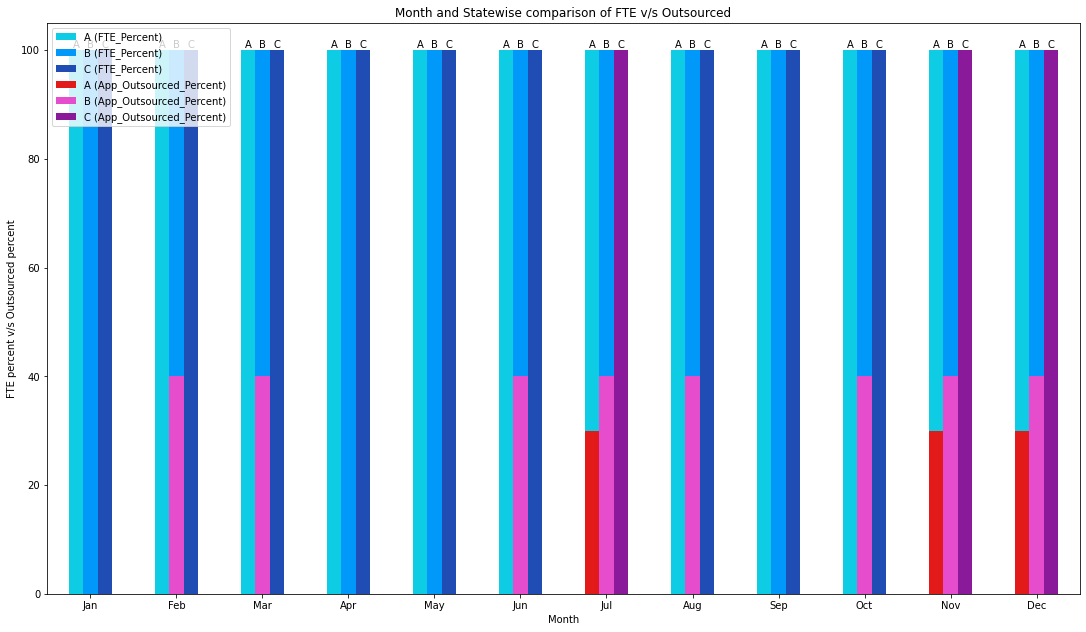

In [77]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
(df0['FTE_Percent']+df0['App_Outsourced_Percent']).plot(kind='bar', color=[(0.05, 0.80, 0.89), (0.0, 0.6, 0.98),(0.12, 0.3, 0.7)], rot=0, ax=ax)
df0['App_Outsourced_Percent'].plot(kind='bar', color=[(0.89, 0.10, 0.10), (0.9, 0.3, 0.8), (0.54, 0.1, 0.6)], rot=0, ax=ax)

legend_labels = [f'{state} ({param})' for param, state in df0.columns]
ax.legend(legend_labels, loc="best")

rects = ax.patches
labels = ['A'] * 12 + ['B']*12 + ['C']*12

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha="center", va="bottom"
    )

plt.ylabel("FTE percent v/s Outsourced percent")
plt.title("Month and Statewise comparison of FTE v/s Outsourced")
plt.show()

### Other graphs have been put directly in the report

# State wise analysis

In [78]:
state_df = FTE_StaffAvPer.copy()
state_df.head()

,State,Month,Demand,Staff Availability,FTE,App_Outsourced
0,A,Jan,5240,0.81,161.728395,0.0
1,A,Feb,4878,0.76,160.460526,0.0
2,A,Mar,5942,0.75,198.066667,0.0
3,A,Apr,2297,0.80,71.781250,0.0
4,A,May,1992,0.78,63.846154,0.0


In [79]:
state_df["FTE_App"] = state_df["FTE"]*state_df["Staff Availability"]*FTE_AppServeRate
state_df.head()

,State,Month,Demand,Staff Availability,FTE,App_Outsourced,FTE_App
0,A,Jan,5240,0.81,161.728395,0.0,5240.0
1,A,Feb,4878,0.76,160.460526,0.0,4878.0
2,A,Mar,5942,0.75,198.066667,0.0,5942.0
3,A,Apr,2297,0.80,71.781250,0.0,2297.0
4,A,May,1992,0.78,63.846154,0.0,1992.0


In [80]:
state_df = state_df.groupby("State")[["Demand","FTE","FTE_App", "App_Outsourced"]].sum()
state_df.head()

,Demand,FTE,FTE_App,App_Outsourced
State,,,,
A,48084,1468.670479,43645.0,4439.0
B,42961,1067.576960,32101.0,10860.0
C,22249,549.261053,16799.0,5450.0


In [81]:
state_df["FTE_Percent"] = state_df["FTE_App"]*100/state_df["Demand"]
state_df["App_Outsourced_Percent"] = state_df["App_Outsourced"]*100/state_df["Demand"]
state_df

,Demand,FTE,FTE_App,App_Outsourced,FTE_Percent,App_Outsourced_Percent
State,,,,,,
A,48084,1468.670479,43645.0,4439.0,90.768239,9.231761
B,42961,1067.576960,32101.0,10860.0,74.721259,25.278741
C,22249,549.261053,16799.0,5450.0,75.504517,24.495483


In [82]:
cost_per_month_state = {'A':5000,'B':4583.333333,'C':4416.666666}
state_df["FTE Cost per month"] = state_df.index.map(cost_per_month_state)
state_df

,Demand,FTE,FTE_App,App_Outsourced,FTE_Percent,App_Outsourced_Percent,FTE Cost per month
State,,,,,,,
A,48084,1468.670479,43645.0,4439.0,90.768239,9.231761,5000.000000
B,42961,1067.576960,32101.0,10860.0,74.721259,25.278741,4583.333333
C,22249,549.261053,16799.0,5450.0,75.504517,24.495483,4416.666666


In [83]:
outsource_cost_per_app = {'A':180,'B':150,'C':160}
state_df["Outsource Cost per App"] = state_df.index.map(outsource_cost_per_app)
state_df

,Demand,FTE,FTE_App,App_Outsourced,FTE_Percent,App_Outsourced_Percent,FTE Cost per month,Outsource Cost per App
State,,,,,,,,
A,48084,1468.670479,43645.0,4439.0,90.768239,9.231761,5000.000000,180
B,42961,1067.576960,32101.0,10860.0,74.721259,25.278741,4583.333333,150
C,22249,549.261053,16799.0,5450.0,75.504517,24.495483,4416.666666,160


In [84]:
state_df["Total Cost"] = state_df["FTE"]*state_df["FTE Cost per month"] + state_df["App_Outsourced"] * state_df["Outsource Cost per App"]
state_df

,Demand,FTE,FTE_App,App_Outsourced,FTE_Percent,App_Outsourced_Percent,FTE Cost per month,Outsource Cost per App,Total Cost
State,,,,,,,,,
A,48084,1468.670479,43645.0,4439.0,90.768239,9.231761,5000.000000,180,8.142372e+06
B,42961,1067.576960,32101.0,10860.0,74.721259,25.278741,4583.333333,150,6.522061e+06
C,22249,549.261053,16799.0,5450.0,75.504517,24.495483,4416.666666,160,3.297903e+06


In [85]:
state_df["Total Cost per App"] = state_df["Total Cost"]/state_df["Demand"]
state_df

,Demand,FTE,FTE_App,App_Outsourced,FTE_Percent,App_Outsourced_Percent,FTE Cost per month,Outsource Cost per App,Total Cost,Total Cost per App
State,,,,,,,,,,
A,48084,1468.670479,43645.0,4439.0,90.768239,9.231761,5000.000000,180,8.142372e+06,169.336420
B,42961,1067.576960,32101.0,10860.0,74.721259,25.278741,4583.333333,150,6.522061e+06,151.813530
C,22249,549.261053,16799.0,5450.0,75.504517,24.495483,4416.666666,160,3.297903e+06,148.227021


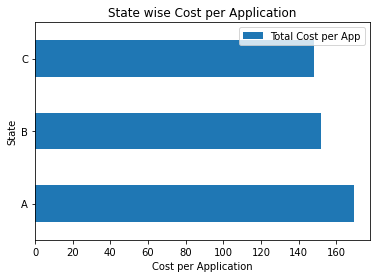

In [86]:
state_df.plot.barh(y="Total Cost per App")
plt.xlabel("Cost per Application")
plt.title("State wise Cost per Application")
plt.show()

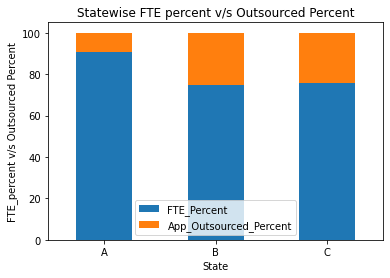

In [87]:
state_df[["FTE_Percent","App_Outsourced_Percent"]].plot(kind="bar",stacked=True)
plt.legend(loc='best')
plt.xticks(rotation=360)
plt.ylabel("FTE_percent v/s Outsourced Percent")
plt.title("Statewise FTE percent v/s Outsourced Percent")
plt.show()

# Insights

- From the Best case and Worst case analysis we can conclude that, less the availability of staff which means more the percentage of outsourced applications, the company has to incur more cost.
- In Best case scenario the total cost decreased by 1.44 million dollars while for worst case it increased by 1.63 million dollars
- From the state wise analysis we see state A has the highest cost per application while state C has the lowest cost per application.
- Also, we see that state A has the lowest percentage of outsourced applications as compared to other states.